In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

Load data - from raw version

torch.float32 torch.Size([36, 3, 49, 49])
torch.float32 torch.Size([36, 1])
torch.float32 torch.Size([36, 1])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.4039, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


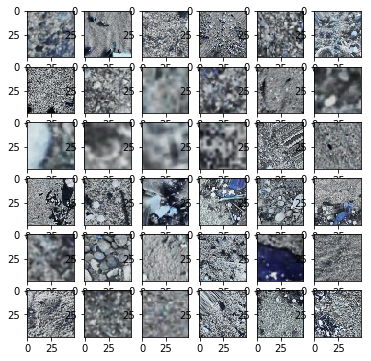

In [2]:
class RawDataset(Dataset):
    def __init__(self):
        s = 49
        self.imgin = np.fromfile("images/data_in.raw", dtype=np.uint8)
        self.imgin = self.imgin.reshape((len(self.imgin)//(3*s*s), 3, s, s))
        self.imgout = np.fromfile("images/data_out.raw", dtype=np.uint8)
        self.imgweight = np.fromfile("images/data_weight.raw", dtype=np.float32)
        self.imgweight = self.imgweight ** 0.5
        self.imgmean = np.fromfile("images/data_mean.raw", dtype=np.float32)
        self.imginvstdev = np.fromfile("images/data_invstdev.raw", dtype=np.float32)
        self.imgmean = self.imgmean.reshape((len(self.imgin), 3))
        self.imginvstdev = self.imginvstdev.reshape((len(self.imgin), 3))
        self.size = s

    def __len__(self):
        nin = self.imgin.shape[0]
        nout = len(self.imgout)
        assert nin == nout
        return nin

    def __getitem__(self, i):
        img = self.imgin[i].astype(np.float32) / 255.0
        for _ in range(3):
            img[_] = (img[_]-self.imgmean[i,_])*self.imginvstdev[i,_]
        imgmin = np.minimum(np.minimum(img[0], img[1]), img[2])
        imgmax = np.maximum(np.maximum(img[0], img[1]), img[2])
        img[0], img[1], img[2] = (
            imgmin,
            img[0]+img[1]+img[2]-imgmin-imgmax,
            imgmax
        )
        return [
            img,
            self.imgout[i:i+1].astype(np.float32) / 255.0,
            self.imgweight[i:i+1]
        ]

dataset = RawDataset()
for imgin, imgout, imgweight in DataLoader(
    dataset,
    batch_size=36,
    shuffle=True
):
    print(imgin.dtype, imgin.shape)
    print(imgout.dtype, imgout.shape)
    print(imgweight.dtype, imgweight.shape)
    n = int(imgin.shape[0]**0.5)

    imgout = imgout.reshape((n, n))
    print(imgout)

    imgin = np.einsum('acij->aijc', imgin.numpy())

    plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        img = imgin[i]
        plt.imshow(1.0/(1.0+np.exp(-img)))

    plt.show()
    break

Model

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        n = 4
        model = [
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 33x33
            nn.Conv2d(3, n, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        for _ in range(10):
            model += [
                nn.Conv2d(n, n, 3, 1, 0, bias=False),
                nn.ZeroPad2d(-1),
                nn.BatchNorm2d(n),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        model += [
            # 3 x 5x5
            nn.Conv2d(n, 1, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            # 1 x 1x1
            nn.Sigmoid()
        ]
        self.main = nn.Sequential(*model)
    
    def forward(self, x):
        return self.main(x)

model = Model()
print(model)

Model(
  (main): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (12): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(4, 4, kerne

Run this only when need to restore model

In [4]:
import re
html = open("../index.html", "r").read()
loaded_bns = {}
for line in re.findall(r"bn\d\d\d\: \[[\d\.\-\,\s]+\]", html):
    name = line[:line.find(":")]
    data = eval(line[line.find('[')-1:])
    loaded_bns[name] = torch.tensor(data, requires_grad=True)

param_i = 0
bn_i = 0
bns = []
for param in model.parameters():
    data = param.data
    shape = '_'.join(map(str, data.shape))
    if len(data.shape) == 1:
        name = "bn{:02d}{}".format(bn_i//2, bn_i%2)
        param.data.copy_(loaded_bns[name])
        bn_i += 1
        continue
    name = "w{:02d}_{}".format(param_i, shape)
    w = np.fromfile("weights/"+name+".bin", dtype=np.float32)
    w = torch.tensor(w.reshape(data.shape), requires_grad=True)
    param.data.copy_(w)
    param_i += 1


Training

In [5]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.005, betas=(0.9, 0.999))


lossFun = torch.nn.BCELoss
flatten = torch.nn.Flatten()

print("ADAM")
count = 0
for epoch in range(1, 10+1):
    print("Epoch", epoch)
    for nin, nout, nweight in dataloader:
        optimizer.zero_grad()
        output = flatten(model(nin))
        loss = lossFun(nweight)(output, nout)
        loss.backward()
        optimizer.step()
        count += 1
        if count % 200 == 0:
            print("Iteration {} - loss = {}".format(count, loss.item()))

ADAM
Epoch 1
Iteration 200 - loss = 0.1484491378068924
Iteration 400 - loss = 0.04705921187996864
Iteration 600 - loss = 0.03128591179847717
Iteration 800 - loss = 0.11535395681858063
Iteration 1000 - loss = 0.016158675774931908
Iteration 1200 - loss = 0.04255281388759613
Iteration 1400 - loss = 0.017687153071165085
Iteration 1600 - loss = 0.10959164798259735
Epoch 2
Iteration 1800 - loss = 0.055745989084243774
Iteration 2000 - loss = 0.05472814664244652
Iteration 2200 - loss = 0.03849026560783386
Iteration 2400 - loss = 0.1325100064277649
Iteration 2600 - loss = 0.1214669942855835
Iteration 2800 - loss = 0.02632851153612137
Iteration 3000 - loss = 0.0758192241191864
Iteration 3200 - loss = 0.02765667252242565
Epoch 3
Iteration 3400 - loss = 0.16551344096660614
Iteration 3600 - loss = 0.06072651594877243
Iteration 3800 - loss = 0.06937512010335922
Iteration 4000 - loss = 0.020917769521474838
Iteration 4200 - loss = 0.06434117257595062
Iteration 4400 - loss = 0.03996885567903519
Iterati

Calculate running mean and variance

In [7]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True
))

for nin, nout, nweight in dataloader:
    with torch.no_grad():
        output = flatten(model(nin))
        loss = lossFun(nweight)(output, nout)
        print(loss)

tensor(0.0526)


Export

In [8]:
import os
os.system("rm weights/*")

param_i = 0
bn_i = 0
bns = []
for param in model.parameters():
    data = param.data
    shape = '_'.join(map(str, data.shape))
    if len(data.shape) == 1:
        name = "bn{:02d}{}".format(bn_i//2, bn_i%2)
        bns.append((name, data))
        bn_i += 1
        continue
    name = "w{:02d}_{}".format(param_i, shape)
    data.numpy().astype(np.float32).tofile("weights/"+name+".bin")
    param_i += 1

bn_i = 0
for layer in model.main:
    if layer.__class__.__name__ != "BatchNorm2d":
        continue
    layer.track_running_stats = False  # freeze
    mu = layer.running_mean
    var = layer.running_var
    name = "bn{:02d}2".format(bn_i)
    bns.append((name, mu))
    name = "bn{:02d}3".format(bn_i)
    bns.append((name, var))
    bn_i += 1

bns.sort()
for name, data in bns:
    s = '[' + ', '.join(map(str, data.numpy())) + ']'
    print(f"{name}: {s},")

bn000: [0.9197908, 0.0465193, 1.2882873],
bn001: [-1.4113542, -0.99027884, -1.549712],
bn002: [-0.092834055, -0.0006767086, 0.09191713],
bn003: [0.6166049, 0.6205143, 0.62054044],
bn010: [1.1540049, 0.66129327, 1.3521965, 1.1185907],
bn011: [-1.9064113, -1.6548927, -1.0744787, 0.9324001],
bn012: [-0.37524948, -0.875453, 0.10024495, 0.66012806],
bn013: [2.8518245, 0.72462535, 0.3228514, 2.1724477],
bn020: [1.5912269, 1.1407832, 1.191435, 0.30240688],
bn021: [-1.0267766, -0.11500661, -1.014453, -0.84068406],
bn022: [0.75345236, 3.1479154, -3.0317547, -4.4451766],
bn023: [15.787811, 16.364836, 21.29051, 11.138737],
bn030: [0.36071834, 0.96799165, 0.43514958, 1.1580708],
bn031: [-2.4892092, -1.8675451, -1.4996156, -0.9795313],
bn032: [-1.6795278, -0.5682734, 4.1194997, 0.37324077],
bn033: [23.47609, 11.050371, 53.685783, 13.338636],
bn040: [0.7489274, 1.3391112, 1.3290538, 1.1039081],
bn041: [-1.9848002, -0.28868064, -0.8846384, -1.5129827],
bn042: [0.29024372, 0.111275055, -1.5272077, 2.3